Скрипт для компрессии и декомпрессии данных в игре Felix The Cat [NES]
--

Декомпрессия
---

Считывание данных из ROM, для удобства конвертируем их из символов в числа

In [5]:
from cadEditorPath import cadEditorDir
import os

romName = os.path.join(cadEditorDir, "Felix the Cat (U) [!].nes")
with open(romName, "rb") as f:
    d = f.read()
d = map(ord, d)

Вспомогательные функции

In [6]:
def readWord(d, addr):
    return d[addr+1]<<8 | d[addr]

def wordToBytes(word):
    return word&0xFF, word>>8

#прибавление адресов банков
def addPtrToLinesPtr(addr, levelNo):
    if levelNo == 0:
        return addr + 0x10010
    elif levelNo == 1:
        return addr + 0xC010
    else:
        return -1

def addPtrToCompress(addr, levelNo):
    return addPtrToLinesPtr(addr, levelNo)

#маскирование ненужных бит из адреса линий, которые кодируют информацию о списке объектов
def removeObjBits(addr):
    if addr < 0x8000:
        addr += 0x8000
    if addr > 0xC000:
        addr -= 0x4000
    return addr

#прибавление адресов банков
def addBankOffset(addr, levelNo):
    if (levelNo == 0):
        return addr + 0x10010
    elif (levelNo == 1):
        return addr + 0xc010
    
#расчёт адресов линий
def addPtrToLines(addr, levelNo):
    addr = removeObjBits(addr)
    return addBankOffset(addr, levelNo)

Чтение поинтеров на массив адресов линий и словарь для распаковки из ROM

In [7]:
LEVEL_NO = 1
if LEVEL_NO == 0:
    linesPtrsAddr = addPtrToLinesPtr(readWord(d,0x27e),0)
    compressAddr = addPtrToLinesPtr(readWord(d,0x280), 0)
elif LEVEL_NO == 1:
    linesPtrsAddr = addPtrToLinesPtr(readWord(d,0x2DE),1)
    compressAddr = addPtrToCompress(readWord(d,0x2E0), 1)
    
print "Lines array addr   :", hex(linesPtrsAddr)
print "Compress dict addr :", hex(compressAddr)

Lines array addr   : 0x166f2
Compress dict addr : 0x16559


Чтение RLE-словаря для распаковки

In [8]:
def readCompress(d, addr):
    ans = []
    for c in xrange(128):
        ans.append((d[addr], d[addr+1]))
        addr += 2
    return ans

In [9]:
compressedArr = readCompress(d, compressAddr)
print "Compressed Array:", compressedArr

Compressed Array: [(24, 0), (12, 0), (10, 21), (11, 0), (2, 21), (10, 23), (18, 0), (4, 3), (6, 0), (3, 3), (19, 0), (16, 0), (2, 0), (2, 3), (9, 0), (2, 125), (7, 0), (2, 5), (3, 5), (8, 0), (4, 5), (5, 5), (17, 0), (6, 5), (7, 5), (15, 0), (8, 5), (14, 0), (9, 5), (13, 0), (10, 5), (5, 0), (11, 5), (2, 16), (3, 16), (4, 16), (5, 16), (10, 0), (3, 0), (4, 0), (2, 83), (2, 86), (3, 86), (3, 100), (12, 5), (4, 1), (13, 5), (14, 5), (3, 1), (3, 21), (2, 1), (3, 50), (2, 50), (6, 88), (5, 88), (4, 87), (3, 87), (4, 35), (4, 36), (2, 71), (2, 89), (2, 117), (2, 118), (3, 35), (3, 36), (2, 87), (2, 88), (3, 88), (11, 20), (13, 21), (13, 1), (4, 88), (10, 20), (5, 21), (4, 50), (6, 21), (5, 20), (5, 23), (4, 21), (9, 20), (9, 23), (6, 20), (7, 21), (6, 23), (2, 20), (2, 23), (14, 20), (3, 112), (15, 21), (5, 1), (8, 21), (11, 35), (11, 36), (9, 21), (7, 89), (4, 89), (10, 35), (10, 36), (5, 50), (12, 20), (24, 21), (5, 112), (6, 1), (21, 74), (110, 72), (80, 67), (75, 15), (72, 80), (71, 71)

Хак для уровня 2 - чтение базовых линий, задающих повторяющуюся мозаику

In [10]:
#hardcode for pyramides levels (2-2 - 2-3)
def decompressLineForBackground(d, t, LINE_HEIGHT = 24):
    index = - (3 + t - 255)
    return decompressLine(d, 0x16627-index*24)

Распаковка одной линии

In [11]:
def decompressLine(d, addr, LINE_HEIGHT = 24):
    #print hex(addr)
    ans = []
    while len(ans) < LINE_HEIGHT:
        v = d[addr]
        #обычный тайл
        if v < 0x80:
            ans.append(v)
        #базовая линия (взять из линии-шаблона первые countFromBackground символов)
        elif v >= 0xFC:
            addr +=1
            backLine = decompressLineForBackground(d, v)
            countFromBackground = d[addr]
            ans.extend(backLine[:countFromBackground])
        #значение из RLE-словаря
        else:
            cv = v & 0x7F
            repeatCount, repeatTile = compressedArr[cv]
            ans.extend([repeatTile]*repeatCount)
        addr += 1
    return ans

Распаковка всех линий уровня

In [12]:
def decompressScreen():
    lines = []
    #actually, it's 3 separate configs for level x-1, x-2, x-3, but it has similar pointers and
    # lie together, so we simple read x3 times to get info of whole level
    WIDTH = 256*3
    HEIGHT = 24
    curLinePtrsAddr = linesPtrsAddr
    for l in xrange(WIDTH):
        #print "CUR_LINE_PTR", hex(curLinePtrsAddr)
        lineAddr = addPtrToLines(readWord(d, curLinePtrsAddr), LEVEL_NO)
        #print "LINE_ADDR", hex(readWord(d, curLinePtrsAddr))
        vals = decompressLine(d, lineAddr, HEIGHT)
        #print vals
        if len(vals) != HEIGHT:
            print "Warning", len(vals)
            print vals
            vals = vals[:HEIGHT]
        ##assert(len(vals)== HEIGHT)
        lines.append(vals)
        curLinePtrsAddr += 2
    return lines

In [13]:
lines = decompressScreen()
screen = [item for sublist in lines for item in sublist]

In [14]:
dumpName = os.path.join(cadEditorDir, "settings_felix_the_cat/dump%d.bin"%(LEVEL_NO+1))
with open(dumpName, "wb") as f:
    v = "".join(map(chr, screen))
    f.write(v)

РЕНДЕР ЛИНИЙ
--
Отрисовка линий

Загружаем классы из редактора CadEditor для загрузки данных о блоках и рендера nes-графики

In [45]:
import clr
clr.AddReference("CadEditor")
clr.AddReference("PluginVideoNes")
import System
from CadEditor import Globals, ConfigScript, MapViewType, UtilsGDI
from PluginVideoNes import Video

from IPython.display import display, Image
picPath = "D:/CadEditorPythonExamples/" #путь к папке для сохранения картинок

Загружаем конфиг для игры Felix (в нём указан способ загрузки блоков из ROM и их адрес), а также используем только что сохранённый дамп данных

In [31]:
configName = cadEditorDir + "settings_felix_the_cat/Settings_Felix_%d.cs"%(LEVEL_NO+1)
Globals.loadData(romName, dumpName, configName)

После успешной загрузки важные данные находятся в:<br>
<b>Globals.romdata</b> – массив байт загруженного ROM.<br>
<b>ConfigScript</b> – все функции загрузки данных из ROM и сохранения их обратно.

In [32]:
#Создаём экземляр плагина для отрисовки NES-графики
video = Video()

Построение блоков уровня

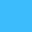

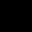

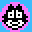

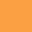

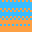

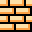

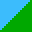

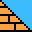

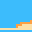

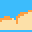

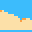

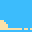

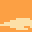

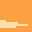

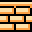

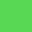

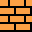

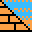

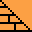

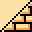

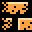

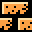

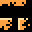

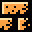

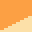

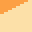

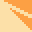

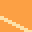

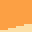

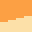

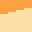

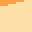

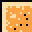

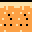

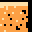

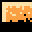

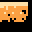

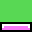

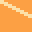

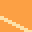

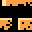

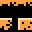

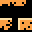

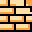

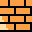

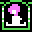

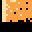

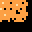

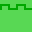

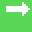

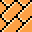

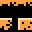

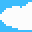

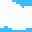

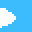

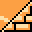

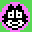

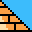

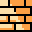

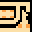

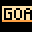

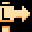

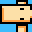

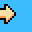

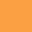

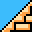

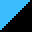

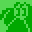

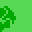

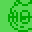

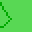

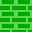

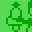

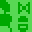

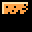

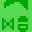

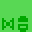

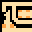

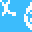

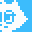

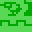

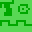

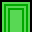

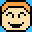

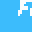

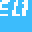

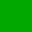

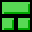

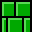

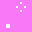

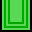

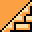

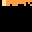

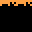

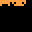

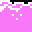

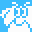

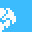

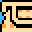

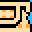

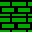

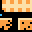

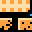

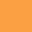

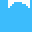

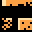

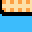

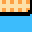

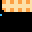

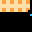

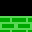

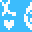

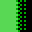

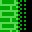

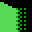

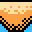

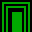

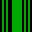

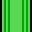

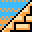

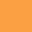

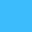

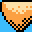

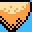

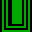

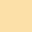

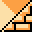

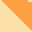

In [38]:
#clr не понимает перегруженных функций, поэтому явно задаём прототип функции, которую хотим вызвать
#Bitmap[] makeObjects(byte videoPageId, byte tilesId, byte palId, float scale, MapViewType drawType, int constantSubpal = -1);
makeObjects = video.makeObjects.Overloads[System.Byte, System.Byte, System.Byte, System.Single, MapViewType, System.Int32]
bb = makeObjects(0x90, 0, 0, 2.0, MapViewType.Tiles, -1)

for i,b in enumerate(bb):
    fn = picPath+"objects%d.png"%i
    b.Save(fn)
    display(Image(filename=fn))

Построение и склейка линий

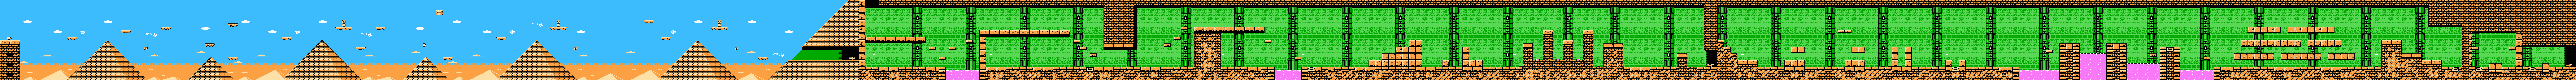

In [63]:
#разворот одномерного массива из постолбцового описания в построчное
def transpose(m, w, h):
    result = [0]*(h*w)
    for i in xrange(w):
        for j in xrange(h):
            result[j * w + i] = m[i * h + j]
    return result

tiles = [bb[i] for i in transpose(screen, 256*3, 24)]
#конвертация в C#-массив
tiles = System.Array[System.Drawing.Image](tiles)
#Склейка линий вместе
tileImage = UtilsGDI.GlueImages(tiles, 256*3, 24)
fn = picPath+"level%d.png"%LEVEL_NO
tileImage.Save(fn)
display(Image(filename=fn))

КОМПРЕССИЯ
---
Пример для уровня 1

In [30]:
from itertools import groupby

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

Считывание сохранённого дампа

In [31]:
dumpName = os.path.join(cadEditorDir, "settings_felix_the_cat/dump1.bin")
with open(dumpName, "rb") as f:
    d = f.read()
    
screen = map(ord, d)

Замена цепочки повторяющихся значений в линии на их индекс в RLE-словаре

In [32]:
def compressorReplace(lines, compressedPair, index):
    #replace with string version of lines for it's great replace method :)
    tc, ti = compressedPair
    findSeq = chr(ti)*tc
    ans = []
    findAtLeastOneReplace = False
    for line in lines:
        rline = "".join(chr(l) for l in line).replace(findSeq, chr(index | 0x80))
        rline = [ord(l) for l in rline]
        if line != rline:
            findAtLeastOneReplace = True
        #print "before:", compressedPair, line, index
        #print "after :", compressedPair, rline, index
        ans.append(rline)
    return ans, findAtLeastOneReplace

Построение потенциального RLE-словаря. Параметр forbiddenArr - список значений, которые не точно не будут использованы при построении реального словаря, используется для итеративного улучшения словаря.

In [27]:
def rebuildCompress(screen, forbiddenArr, maxCompressSize = 256, LINE_LEN=24):
    fullAns = [(0,0)]*maxCompressSize
    lines = list(chunks(screen, LINE_LEN))
    x = 0
    while x < maxCompressSize:
        ans = {}
        for line in lines:
            repeats = [list(g) for _, g in groupby(line)]
            repeats = [(g[0],len(g)) for g in repeats]
            for (tileNo,tileCount) in repeats:
                #for tc in xrange(tileCount, tileCount+1):
                for tc in xrange(2,tileCount+1):
                    compressPair = tileNo, tc
                    if compressPair in ans:
                        ans[compressPair] += 1
                    else:
                        ans[compressPair] = 1
        #рассчёт ценности замены - длины цепочки * частоты её встречаемости
        def calcPoints(v):
            (t,c), cnt = v
            return -(c-1)*cnt
    
        ans = sorted(ans.iteritems(), key = calcPoints)
        #filter and reverse values
        newAns = []
        for a in ans:
            if (a[0][0]) < 0x80:
                newAns.append((a[0][1],a[0][0]))
        
        newAns = filter(lambda v: v not in forbiddenArr, newAns)
        if len(newAns) == 0:
            break
            
        #HINT!!! if first results are similar in points, then we can use it's all
        ansValue = newAns[0][1]
        #newAns = filter(lambda x: x[1]==ansValue, newAns) #comment this for best results!
        #newAns = sorted(newAns, key = lambda x: -x[0])
        #print newAns
        similar, maxSimilar = 0, 256
        while len(newAns) > 0 and x < maxCompressSize and similar < maxSimilar:
            curAns = newAns[0]
            lines, findAtLeastOneReplace = compressorReplace(lines, curAns, x)
            fullAns[x] = curAns
            x += 1
            similar += 1
            newAns = newAns[1:]
    return fullAns

Простая версия построения словаря, без учёта перестройки линий и исключения неиспользуемых значений, для сравнения результатов

In [28]:
def rebuildCompressNoDinamic(screen, maxCompressSize = 64, LINE_LEN=24):
    ans = {}
    for line in chunks(screen, LINE_LEN):
        repeats = [list(g) for _, g in groupby(line)]
        repeats = [(g[0],len(g)) for g in repeats]
        for (tileNo,tileCount) in repeats:
            #for tc in xrange(tileCount, tileCount+1):
            for tc in xrange(2,tileCount+1):
                compressPair = tileNo, tc
                if compressPair in ans:
                    ans[compressPair] += 1
                else:
                    ans[compressPair] = 1
    #--
    def calcPoints(v):
        (t,c), cnt = v
        return -(c-1)*cnt
    
    ans = sorted(ans.iteritems(), key = calcPoints)
    #reverse values
    ans = map (lambda x: (x[0][1],x[0][0]), ans[:maxCompressSize])
    return ans

Построение RLE-словаря

In [34]:
#comment all this cell for no rebuild RLE-dictionary

#!!!
#forbidden = [(15, 15), (14, 15), (13, 15), (15, 5), (22, 124), (21, 124), (14, 5), (3, 108), (2, 112)]
#forbidden.extend([(12, 15), (20, 124), (13, 5), (19, 124), (2, 15), (3, 109)])
#forbidden.extend([(17, 15), (18, 124), (3, 110), (3, 80)])
#forbidden.extend([(11, 15), (2, 5), (2, 80), (0, 0)])
#
compressedArr = rebuildCompress(screen, [])
print "Compression array:", compressedArr

#compressedArr = rebuildCompressNoDinamic(screen)
#print compressedArr

Compression array: [(13, 0), (12, 0), (14, 0), (15, 0), (11, 0), (10, 0), (9, 0), (16, 0), (8, 0), (7, 0), (17, 0), (18, 0), (6, 0), (19, 0), (5, 0), (4, 0), (3, 0), (20, 0), (2, 0), (21, 0), (5, 121), (5, 120), (4, 121), (3, 121), (4, 120), (3, 120), (2, 120), (2, 121), (6, 121), (16, 15), (15, 15), (14, 15), (6, 120), (13, 15), (18, 15), (12, 15), (7, 121), (17, 15), (11, 15), (9, 121), (8, 121), (10, 15), (7, 120), (8, 120), (2, 3), (9, 15), (11, 121), (9, 120), (8, 15), (10, 121), (3, 82), (13, 121), (3, 3), (12, 121), (7, 15), (10, 120), (2, 82), (4, 124), (4, 3), (24, 121), (3, 124), (16, 5), (6, 15), (4, 125), (12, 120), (23, 121), (23, 124), (3, 125), (22, 121), (22, 0), (15, 5), (22, 124), (21, 124), (5, 124), (21, 121), (11, 120), (14, 5), (20, 121), (20, 124), (19, 121), (19, 124), (13, 5), (5, 15), (6, 124), (8, 124), (18, 5), (18, 124), (2, 124), (18, 121), (2, 125), (12, 5), (17, 5), (9, 124), (17, 121), (5, 125), (17, 124), (11, 5), (7, 124), (6, 125), (16, 124), (16, 12

Запаковка строки. Выбирает самую длинную из возможных RLE-цепочек в словаре. Параметр compressedArrUsing возвращает количество использований каждого из значений словаря, что позволяет отследить неиспользуемые значения в словаре

In [35]:
def packRepeat(repeat, compressedArr, compressedArrUsing):
    tileNo, tileCount = repeat
    if tileCount <= 0:
        return []
    if tileCount == 1:
        return [tileNo]
    #---
    maxInd, maxCount = -1, -1
    for (ind,(c,t)) in enumerate(compressedArr):
        if t == tileNo and c <= tileCount:
            if c > maxCount:
                maxCount = c
                maxInd = ind
    if maxInd != -1:
        compressedArrUsing[maxInd] += 1
        return [0x80 | maxInd ] + packRepeat((tileNo, tileCount - maxCount), compressedArr, compressedArrUsing)
    #---
    return [tileNo] + packRepeat((tileNo, tileCount-1), compressedArr, compressedArrUsing)

def compressLine(l, compressedArr, compressedArrUsing):
    repeats = [list(g) for _, g in groupby(l)]
    repeats = [(g[0],len(g)) for g in repeats]
    ans = []
    for r in repeats:
        ans.extend(packRepeat(r, compressedArr, compressedArrUsing))
    return ans


Сжатие целого экрана

In [36]:
def compressScreen(screen, startDataAddr):
    LINE_LEN = 24
    curAddr = startDataAddr
    prevLinesAddrs = {}
    linesAddrs = []
    linesArray = []
    compressedArrUsing = [0] * len(compressedArr)
    for line in chunks(screen, LINE_LEN):
        cline = compressLine(line, compressedArr, compressedArrUsing)
        #print cline, ","
        clineTupple = tuple(cline)
        if clineTupple in prevLinesAddrs:
            linesAddrs.append(prevLinesAddrs[clineTupple])
            continue
        prevLinesAddrs[clineTupple] = curAddr
        linesAddrs.append(curAddr)
        linesArray.extend(cline)
        curAddr += len(cline)
    return linesAddrs, linesArray, compressedArrUsing

Последовательный подбор словаря и сжатие им с очисткой словаря

In [37]:
fullForbiddenArr = []

while True:
    linesAddrs, linesArray, compressedArrUsing = compressScreen(screen, 0xA8ED)
    forbiddenArr = []
    print "Compressed size:", len(linesArray)
    #print compressedArrUsing
    for ca, car in zip(compressedArr, compressedArrUsing):
        if car == 0 and ca != (0,0):
            forbiddenArr.append(ca)
    if forbiddenArr == []:
        break
    fullForbiddenArr.extend(forbiddenArr)
    compressedArr = rebuildCompress(screen, fullForbiddenArr)
compressedArr = filter (lambda v: v!=(0,0), compressedArr)
print "Final compressed arr:", compressedArr

Compressed size: 3740
Compressed size: 3740
Final compressed arr: [(13, 0), (12, 0), (14, 0), (15, 0), (11, 0), (10, 0), (9, 0), (16, 0), (8, 0), (7, 0), (17, 0), (18, 0), (6, 0), (19, 0), (5, 0), (4, 0), (3, 0), (20, 0), (2, 0), (21, 0), (5, 121), (5, 120), (4, 121), (3, 121), (4, 120), (3, 120), (2, 120), (2, 121), (6, 121), (16, 15), (6, 120), (18, 15), (7, 121), (9, 121), (8, 121), (7, 120), (8, 120), (2, 3), (11, 121), (9, 120), (3, 82), (13, 121), (3, 3), (10, 120), (2, 82), (4, 124), (4, 3), (24, 121), (3, 124), (16, 5), (4, 125), (12, 120), (23, 124), (3, 125), (22, 0), (5, 124), (6, 124), (8, 124), (18, 5), (2, 124), (2, 125), (9, 124), (5, 125), (6, 125), (10, 124), (2, 108), (2, 1), (13, 120), (23, 125), (4, 108), (8, 125), (3, 1), (5, 3), (4, 1), (3, 112), (2, 110), (2, 109), (4, 109), (4, 80), (4, 110), (2, 67)]


ПАТЧИНГ РОМА
--
Запаковка сжатых данных обратно в ROM-файл.
Возможны ошибки в случае, если сжатые данные занимают больше места, чем исходные

In [39]:
romPatchLinesArrayAddr = 0x1B93F
romPatchDataArrayAddr  = 0x1A8FD
romPatchCompressArrayAddr = 0x1B799

In [40]:
#convert pointer to bytes
dataLines = []
for addr in linesAddrs:
    dataLines.extend(wordToBytes(addr))

romName = os.path.join(cadEditorDir, "Felix the Cat (U) [!].nes")
romName2 = os.path.join(cadEditorDir, "Felix the Cat (U) [!]-2.nes")
with open(romName, "rb") as f:
    d = f.read()
    d = map(ord, d)

#write lines pointers
for x in xrange(len(dataLines)):
    #we must save some bits in hi-bytes addr, because they used to encoding objects
    if x%2 == 1:
        v = d[romPatchLinesArrayAddr+x]
        v = (v & 0xC0) | (dataLines[x] & 0x3F)
        d[romPatchLinesArrayAddr+x] = v
    else:
        d[romPatchLinesArrayAddr+x] = dataLines[x]
#write lines data
print "Total data written:", len(linesArray)
#print linesArray
d[romPatchDataArrayAddr:romPatchDataArrayAddr+len(linesArray)] = linesArray
#write compress dict
compressedData = [y for x in compressedArr for y in x]
d[romPatchCompressArrayAddr:romPatchCompressArrayAddr+len(compressedData)] = compressedData
with open(romName2, "wb") as f:
    d =  "".join(map(chr, d))
    f.write(d)

Total data written: 3740


<pre>
0. Размер сжатых данных со словарём, используемом в игре: 3740 байт
1. Размер данных со статическим составлением словаря:     3879 байт
(при этом до повтора целых линий - 6313 байт)
2. Размер данных с динамическим составлением словаря:     4695 байт
3. C поправкой на использование неск. возможных значений: 3838 байт
4. С циклическим исключением возможных ошибок:            3817 байт
5. С большим размером словаря:                            3740 байт
</pre>